In [1]:
pip install keras

In [2]:
import gc
import math
import cv2
import glob
import os, shutil
import numpy as np 
import pandas as pd 
from PIL import Image
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/My Drive/Covid Dataset/newdata

/content/gdrive/My Drive/Covid Dataset/newdata


In [5]:
data = pd.read_csv('FinData.csv')
arr = data["label"].unique() 
arr

array([1, 2])

In [8]:
from skimage.filters import unsharp_mask


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


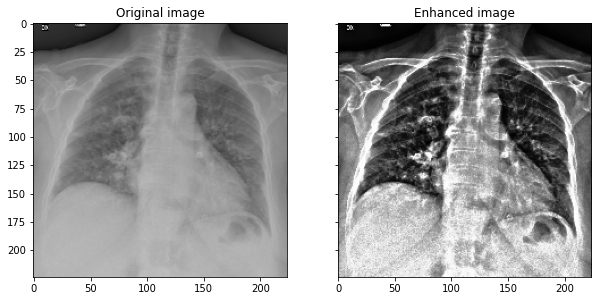

In [9]:
for i in tqdm(range(1,2)):
    img = image.load_img("/content/gdrive/My Drive/Covid Dataset/newdata/" + data['id'][i], target_size=(224,224,3), grayscale=False)
    unsharp_image = unsharp_mask(img, radius=5, amount=2)
    equalized_image = exposure.equalize_hist(unsharp_image)
    equalized_image = image.img_to_array(equalized_image)    
    equalized_image = equalized_image/255
    check = equalized_image*255

fig, axes = plt.subplots(nrows=1, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title('Original image')
ax[1].imshow(check)
ax[1].set_title('Enhanced image')
plt.show()

In [10]:
train_image = []
for i in tqdm(range(data.shape[0])):
    img = image.load_img("/content/gdrive/My Drive/Covid Dataset/newdata/" + data['id'][i], target_size=(224,224,3), grayscale=False)
    unsharp_image = unsharp_mask(img, radius=5, amount=2)
    equalized_image = exposure.equalize_hist(unsharp_image)
    equalized_image = image.img_to_array(equalized_image)    
    equalized_image = equalized_image/255
    train_image.append(equalized_image)
X = np.array(train_image)
print(type(X))
print(img)

  0%|          | 0/657 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
100%|██████████| 657/657 [00:26<00:00, 24.37it/s]


<class 'numpy.ndarray'>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7EFCD30F5E90>


In [11]:
print('x_train shape:', X.shape)

x_train shape: (657, 224, 224, 3)


In [12]:
y_init=data['label'].values
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded.shape)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(onehot_encoded)

    y = onehot_encoded
    #print(y)
    return y, label_encoder, onehot_encoder
y, label_encoder, onehot_encoder = prepare_labels(y_init)
y.shape

(657, 2)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [14]:
print('y_train shape:', y.shape)

y_train shape: (657, 2)


In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

baseModel = DenseNet121(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation='relu')(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(2, activation='softmax')(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)



In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [19]:
from tensorflow.keras.optimizers import Adamax
model.compile(loss='binary_crossentropy',optimizer='adamax',metrics=['accuracy'])

In [20]:
history=model.fit(X_train, y_train, epochs=300, validation_split=0.2,batch_size=32)

Epoch 1/300
14/14 [==============================] - 14s 376ms/step - loss: 1.3673 - accuracy: 0.7024 - val_loss: 0.6598 - val_accuracy: 0.7333
Epoch 2/300
14/14 [==============================] - 2s 113ms/step - loss: 0.7261 - accuracy: 0.7357 - val_loss: 0.5731 - val_accuracy: 0.7333
Epoch 3/300
14/14 [==============================] - 2s 113ms/step - loss: 0.5783 - accuracy: 0.7619 - val_loss: 0.5732 - val_accuracy: 0.7333
Epoch 4/300
14/14 [==============================] - 2s 112ms/step - loss: 0.5465 - accuracy: 0.7905 - val_loss: 0.5587 - val_accuracy: 0.7333
Epoch 5/300
14/14 [==============================] - 2s 113ms/step - loss: 0.5392 - accuracy: 0.7762 - val_loss: 0.5657 - val_accuracy: 0.7333
Epoch 6/300
14/14 [==============================] - 2s 112ms/step - loss: 0.5558 - accuracy: 0.7738 - val_loss: 0.5533 - val_accuracy: 0.7333
Epoch 7/300
14/14 [==============================] - 2s 113ms/step - loss: 0.5339 - accuracy: 0.7881 - val_loss: 0.5735 - val_accuracy: 0.733

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07882767170667648
Test accuracy: 0.9924242496490479


In [22]:
predictions = model.predict(X_test)

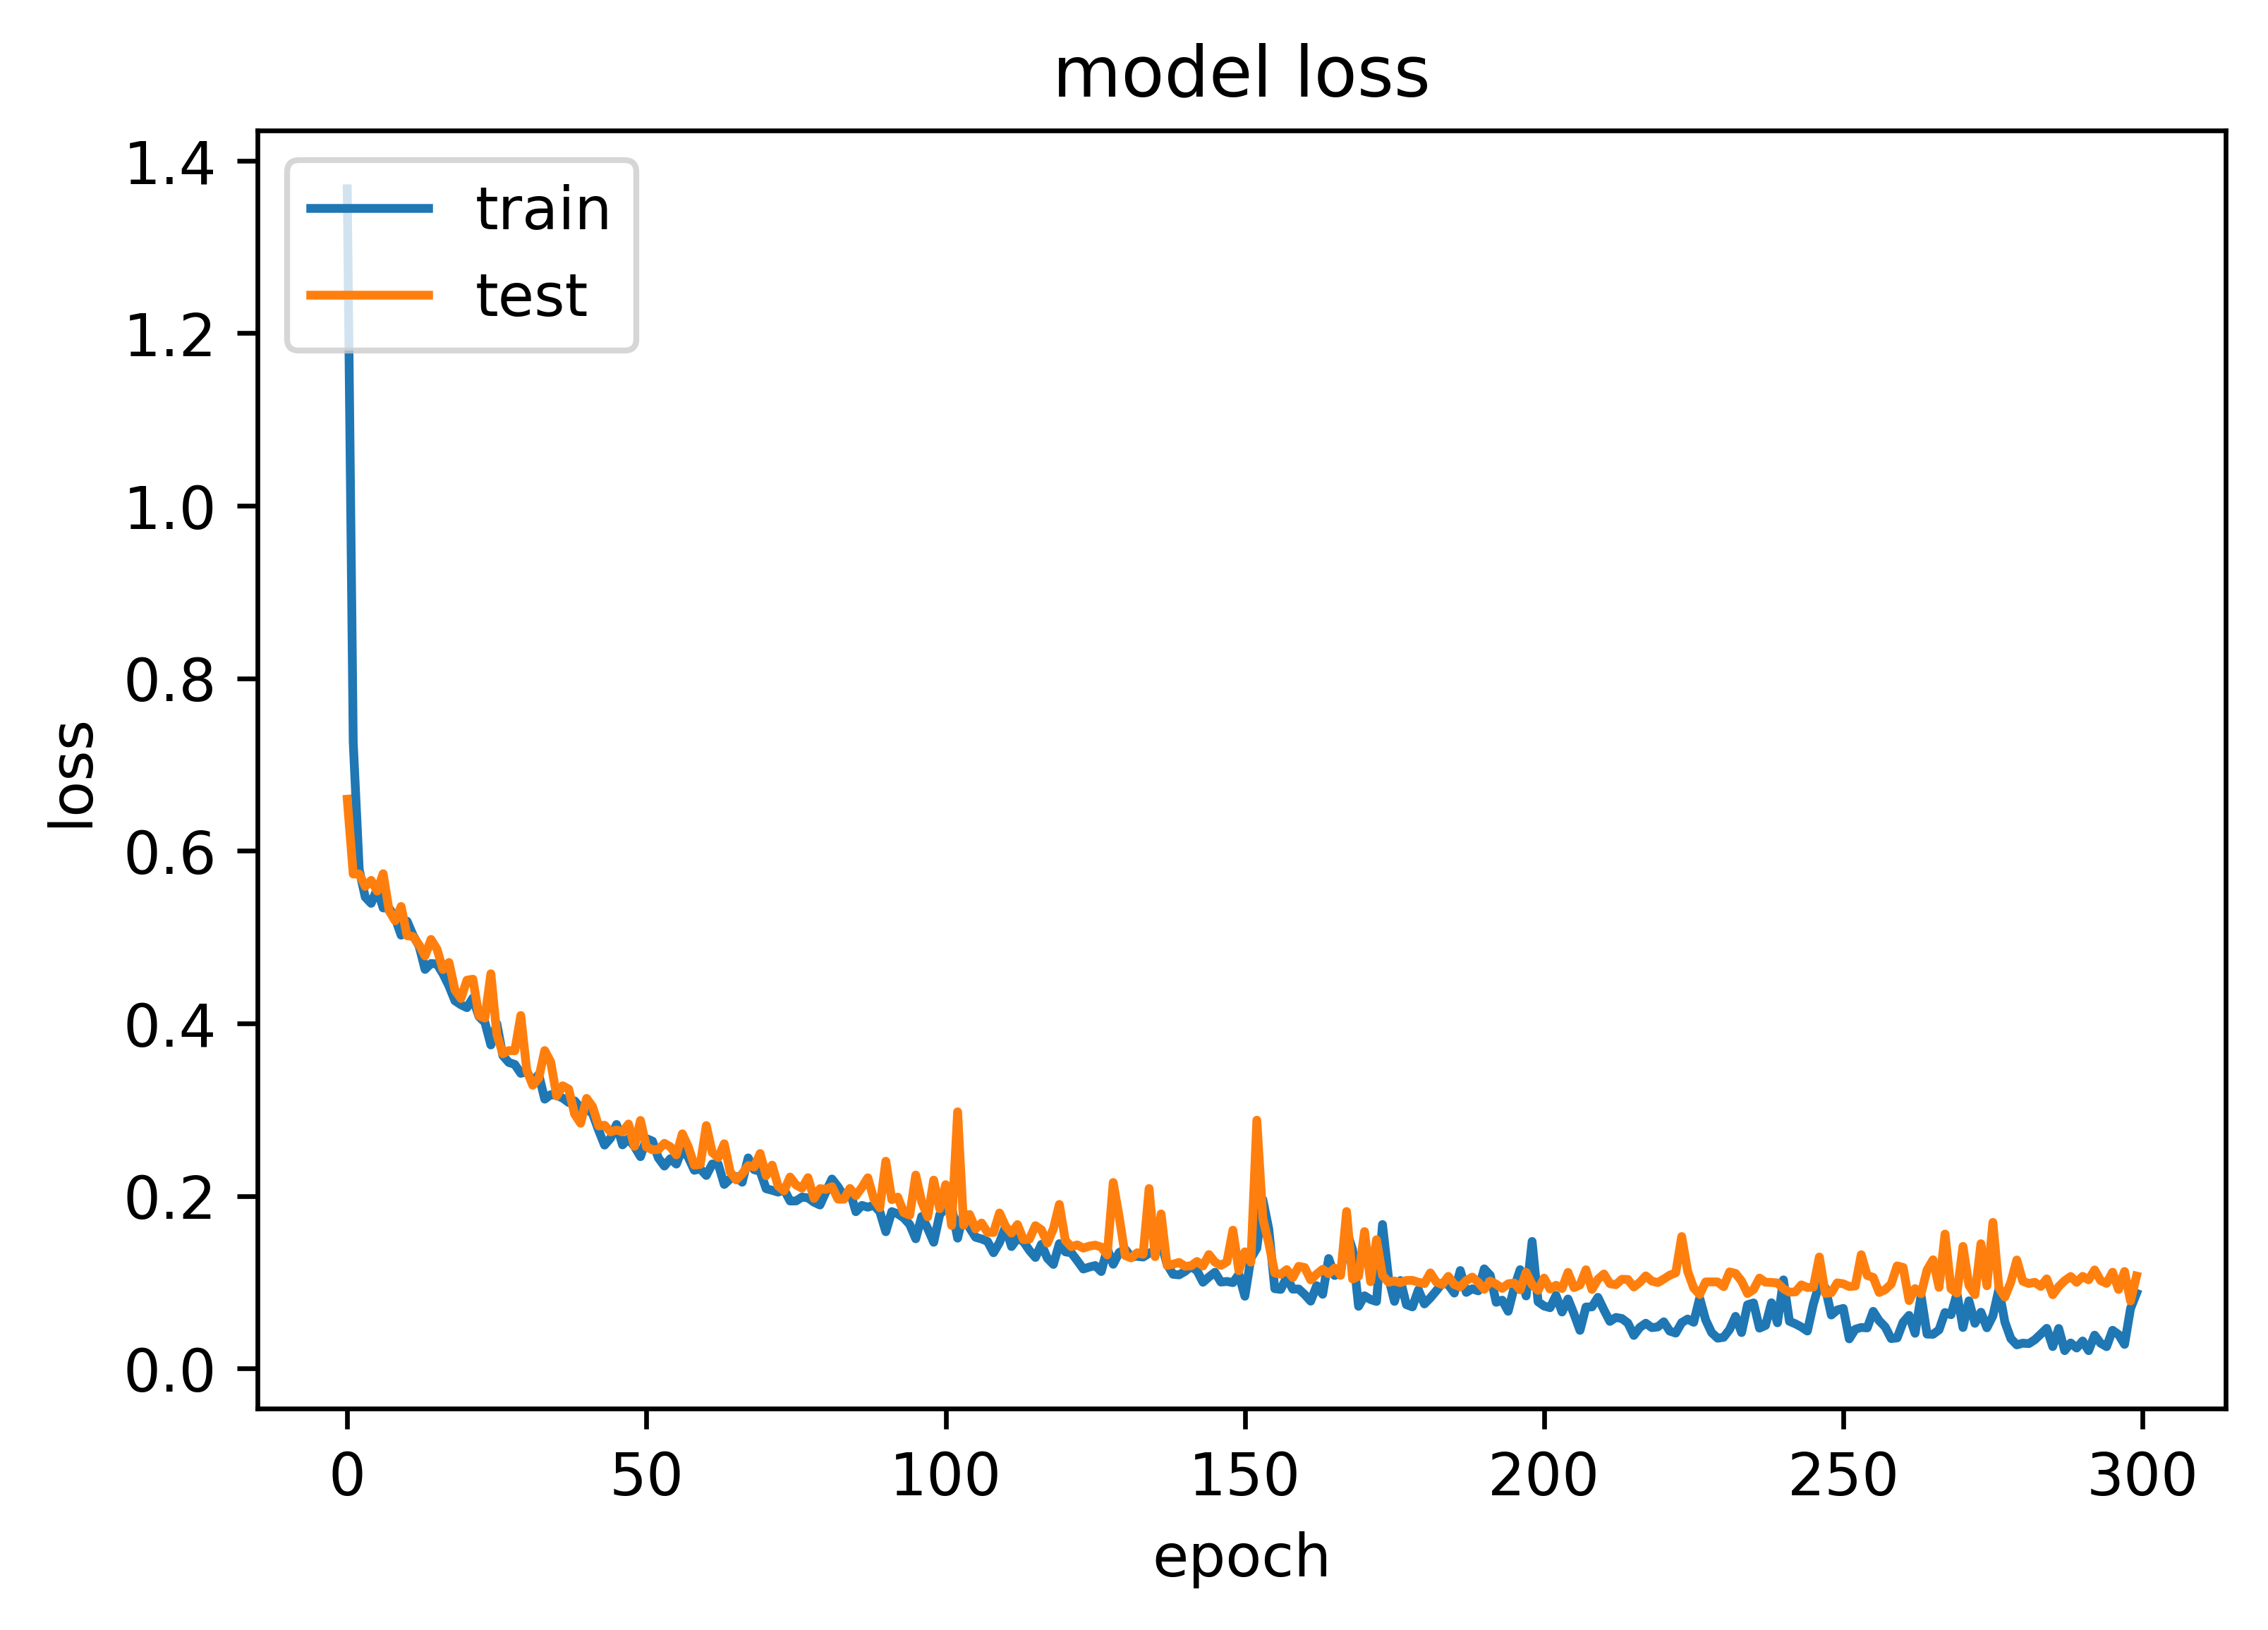

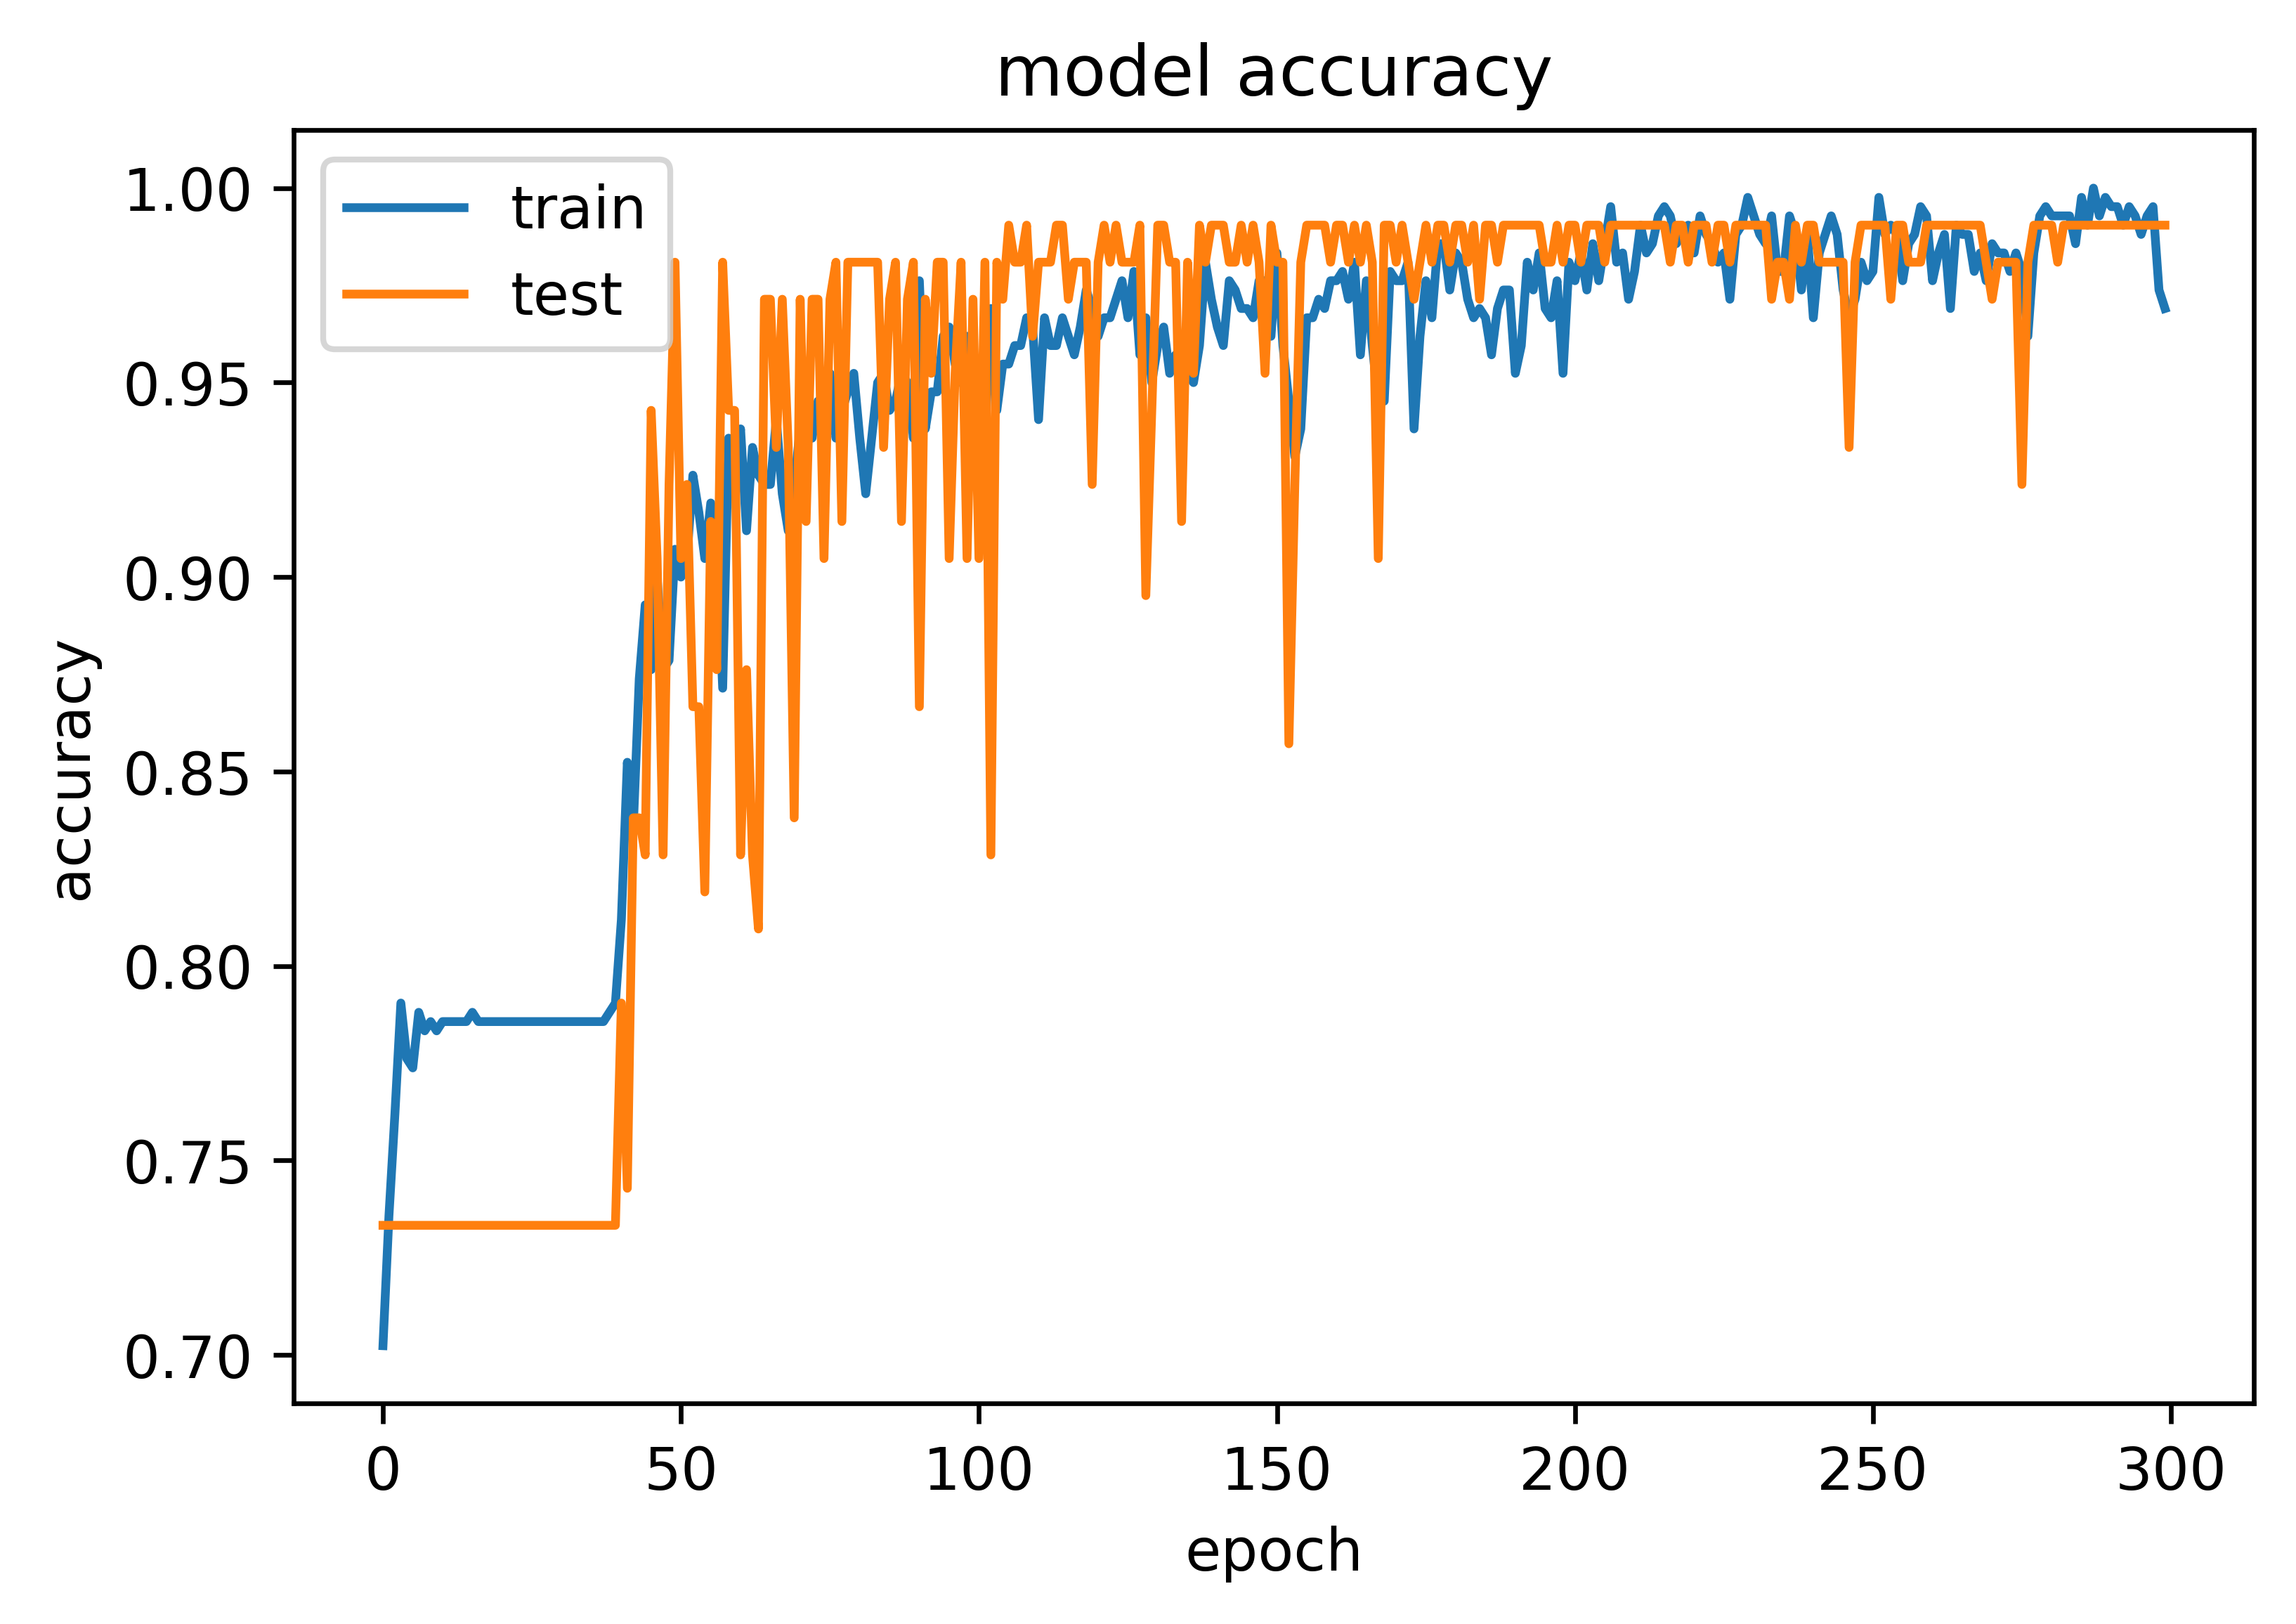

In [23]:
#summarize the hostory for loss
plt.figure(dpi=600)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.figure(dpi=600)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
inte1 = onehot_encoder.inverse_transform(y_test)
fi1 = label_encoder.inverse_transform(inte1)
Y_pred = model.predict(X_test)
inte = onehot_encoder.inverse_transform(Y_pred)
fi = label_encoder.inverse_transform(inte)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


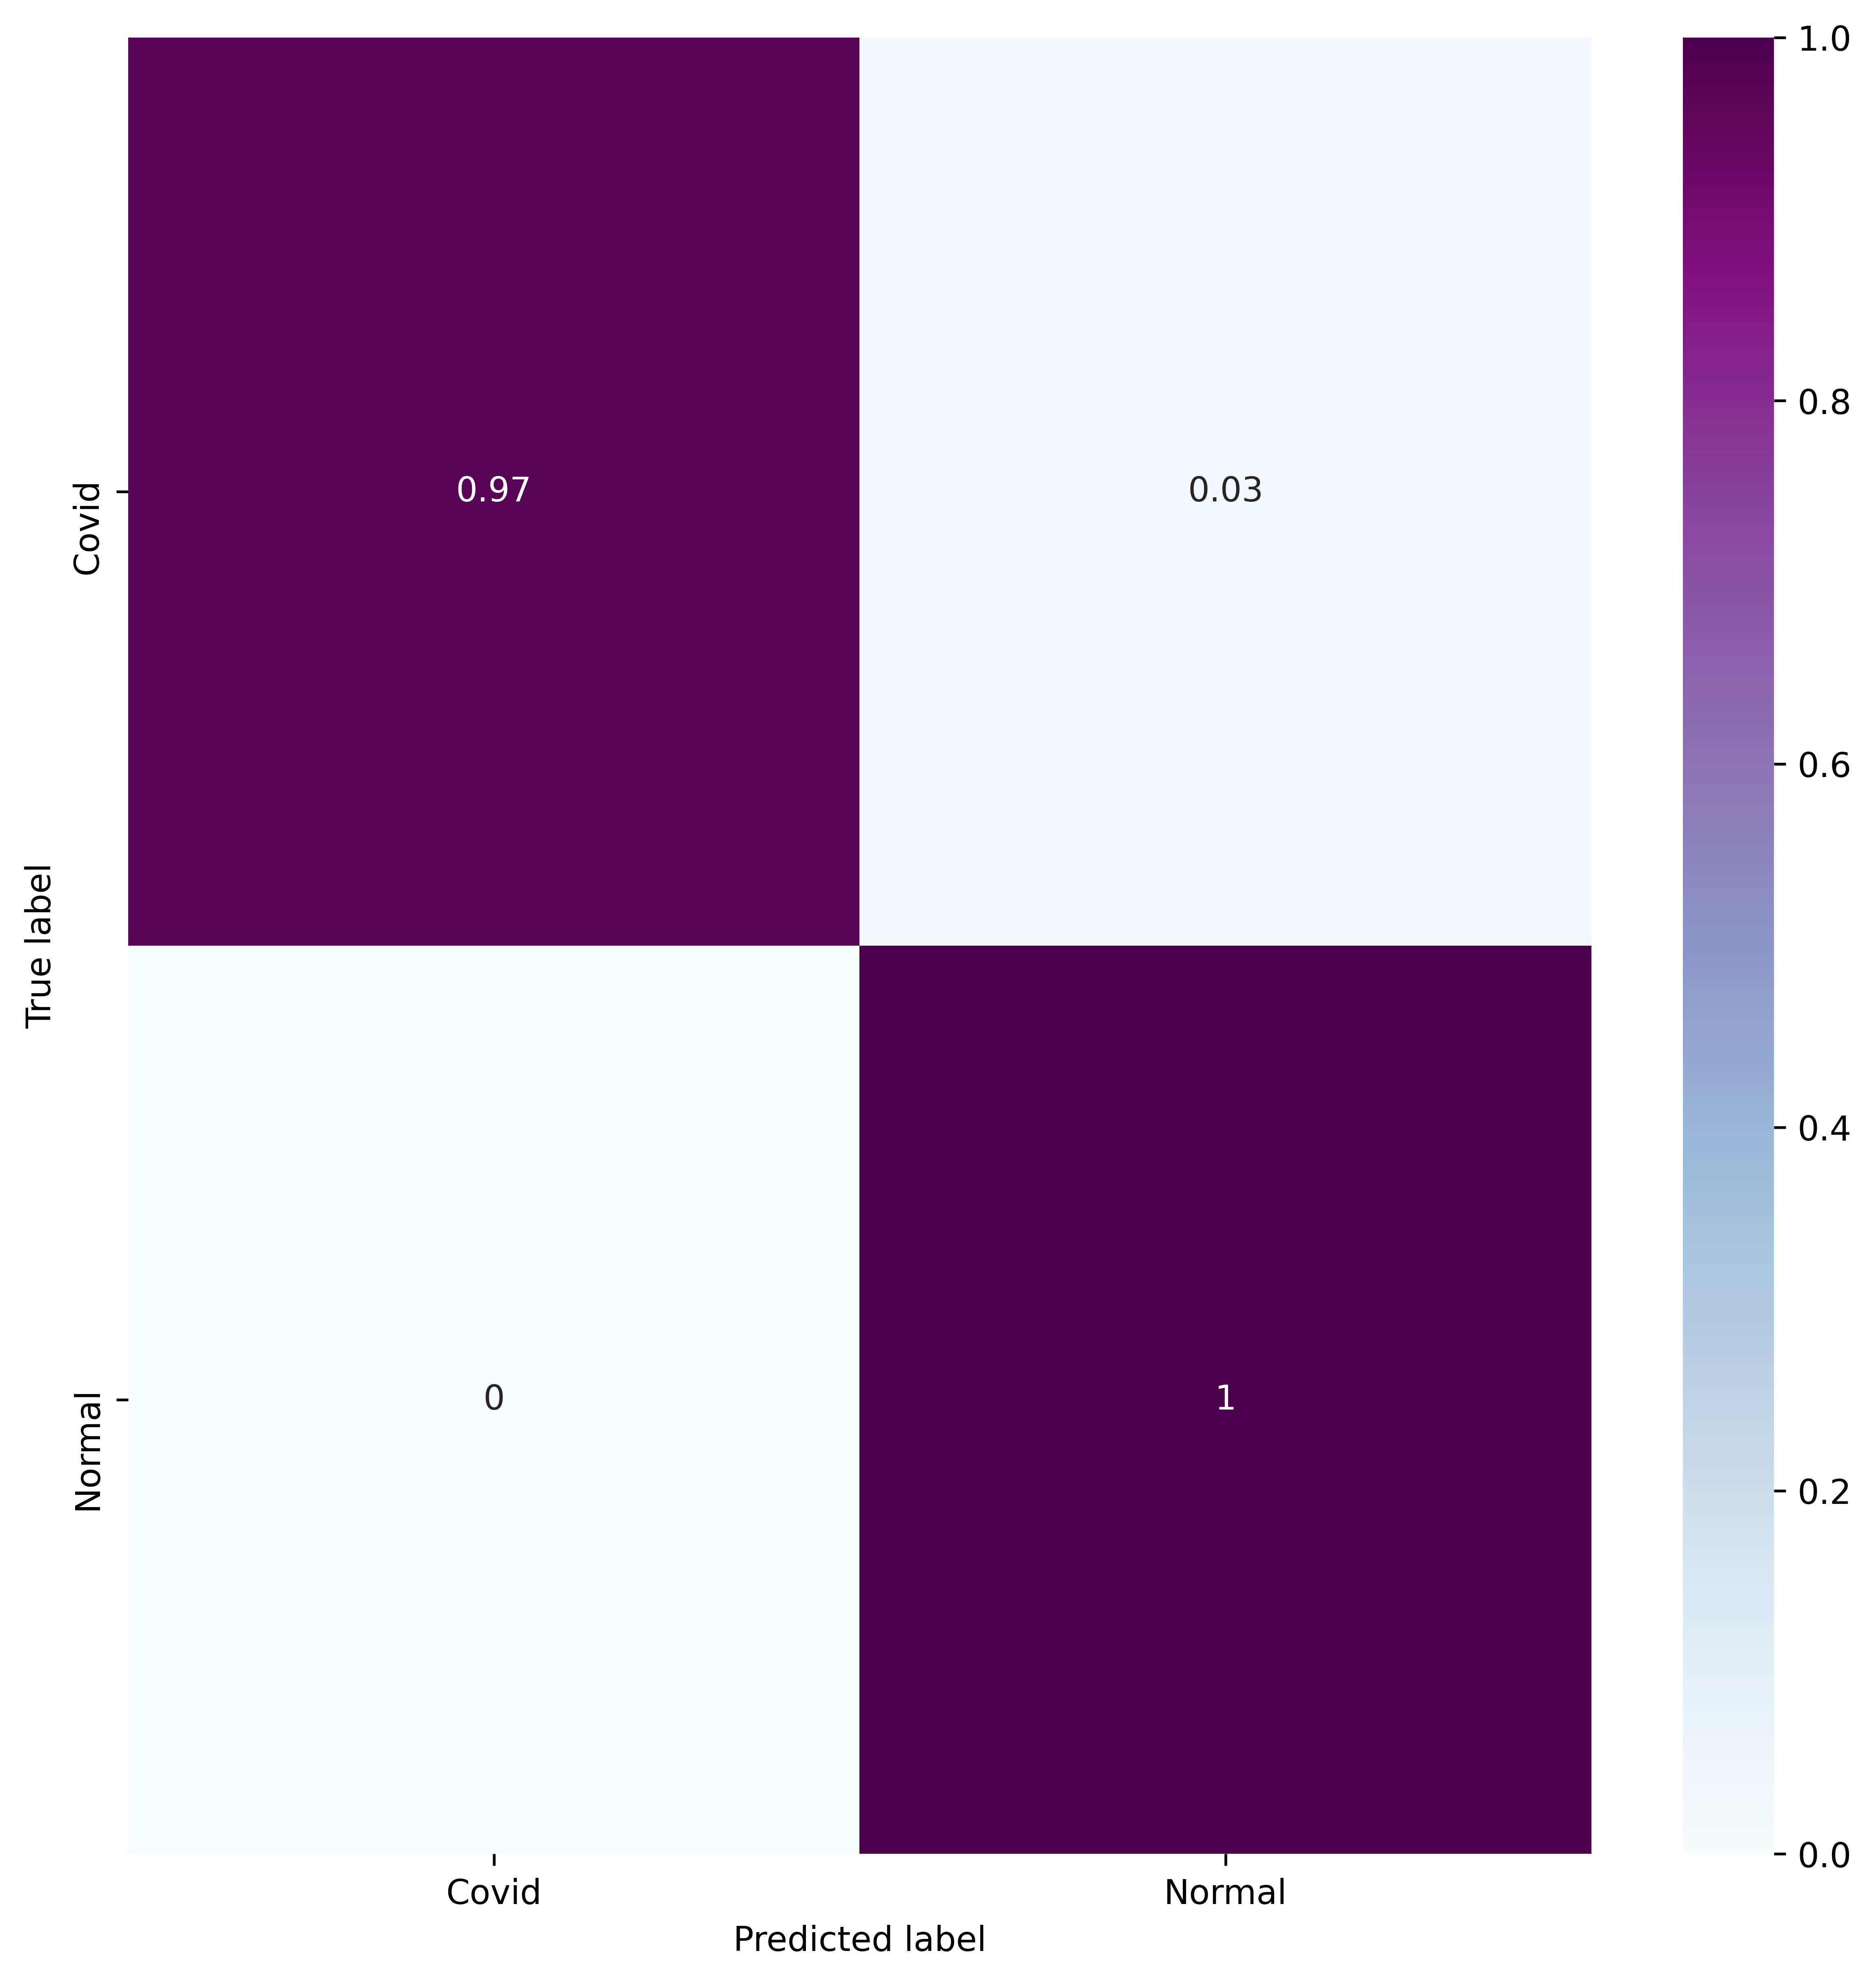

In [25]:
import seaborn as sns
labels=np.argmax(y_test, axis=1)
pred=np.argmax(predictions, axis=1)
target_names=['Covid', 'Normal']
con_mat = confusion_matrix(labels, pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = target_names, 
                     columns = target_names)
figure = plt.figure(figsize=(8, 8),dpi=600)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.BuPu)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [26]:
print("Precision Score : ",precision_score(fi1, fi, pos_label=arr[0], average='binary'))
print("Recall Score : ",recall_score(fi1, fi, pos_label=arr[0],average='binary'))
print('Accuracy Score : ' + str(accuracy_score(fi1,fi)))
print('F1 Score : ' + str(f1_score(fi1,fi, pos_label=arr[0],average='binary')))


Precision Score :  1.0
Recall Score :  0.9743589743589743
Accuracy Score : 0.9924242424242424
F1 Score : 0.9870129870129869


In [27]:
print('Classification Report')
target_names = ['Covid', 'Normal']
print(classification_report(fi1, fi, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Covid       1.00      0.97      0.99        39
      Normal       0.99      1.00      0.99        93

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



In [28]:
cm1=confusion_matrix(labels,pred)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9743589743589743
Specificity :  1.0


In [29]:
print(fi1)
print(len(fi1))
print(fi)
print(len(fi))
tfi1=[]
tfi=[]

for i in fi1:
  if(i==2):
    tfi1.append(0)
  if(i==1):
    tfi1.append(1)

for i in fi:
  if(i==2):
    tfi.append(0)
  if(i==1):
    tfi.append(1)

print(tfi1)
print(len(tfi1))
print(tfi)
print(len(tfi))



[2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1
 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1 2 2 1 2 2
 2 2 2 1 2 1 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 1 2 1 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 1 2 2 1 2 1 2 2 2 1]
132
[2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 1 2 2 1 1 2
 1 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 1 1 1 2 2 1 2 2
 2 2 2 1 2 1 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 1 2 1 2 2 2
 2 2 2 1 2 2 2 2 2 1 2 1 2 2 1 2 1 2 2 2 1]
132
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
132
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

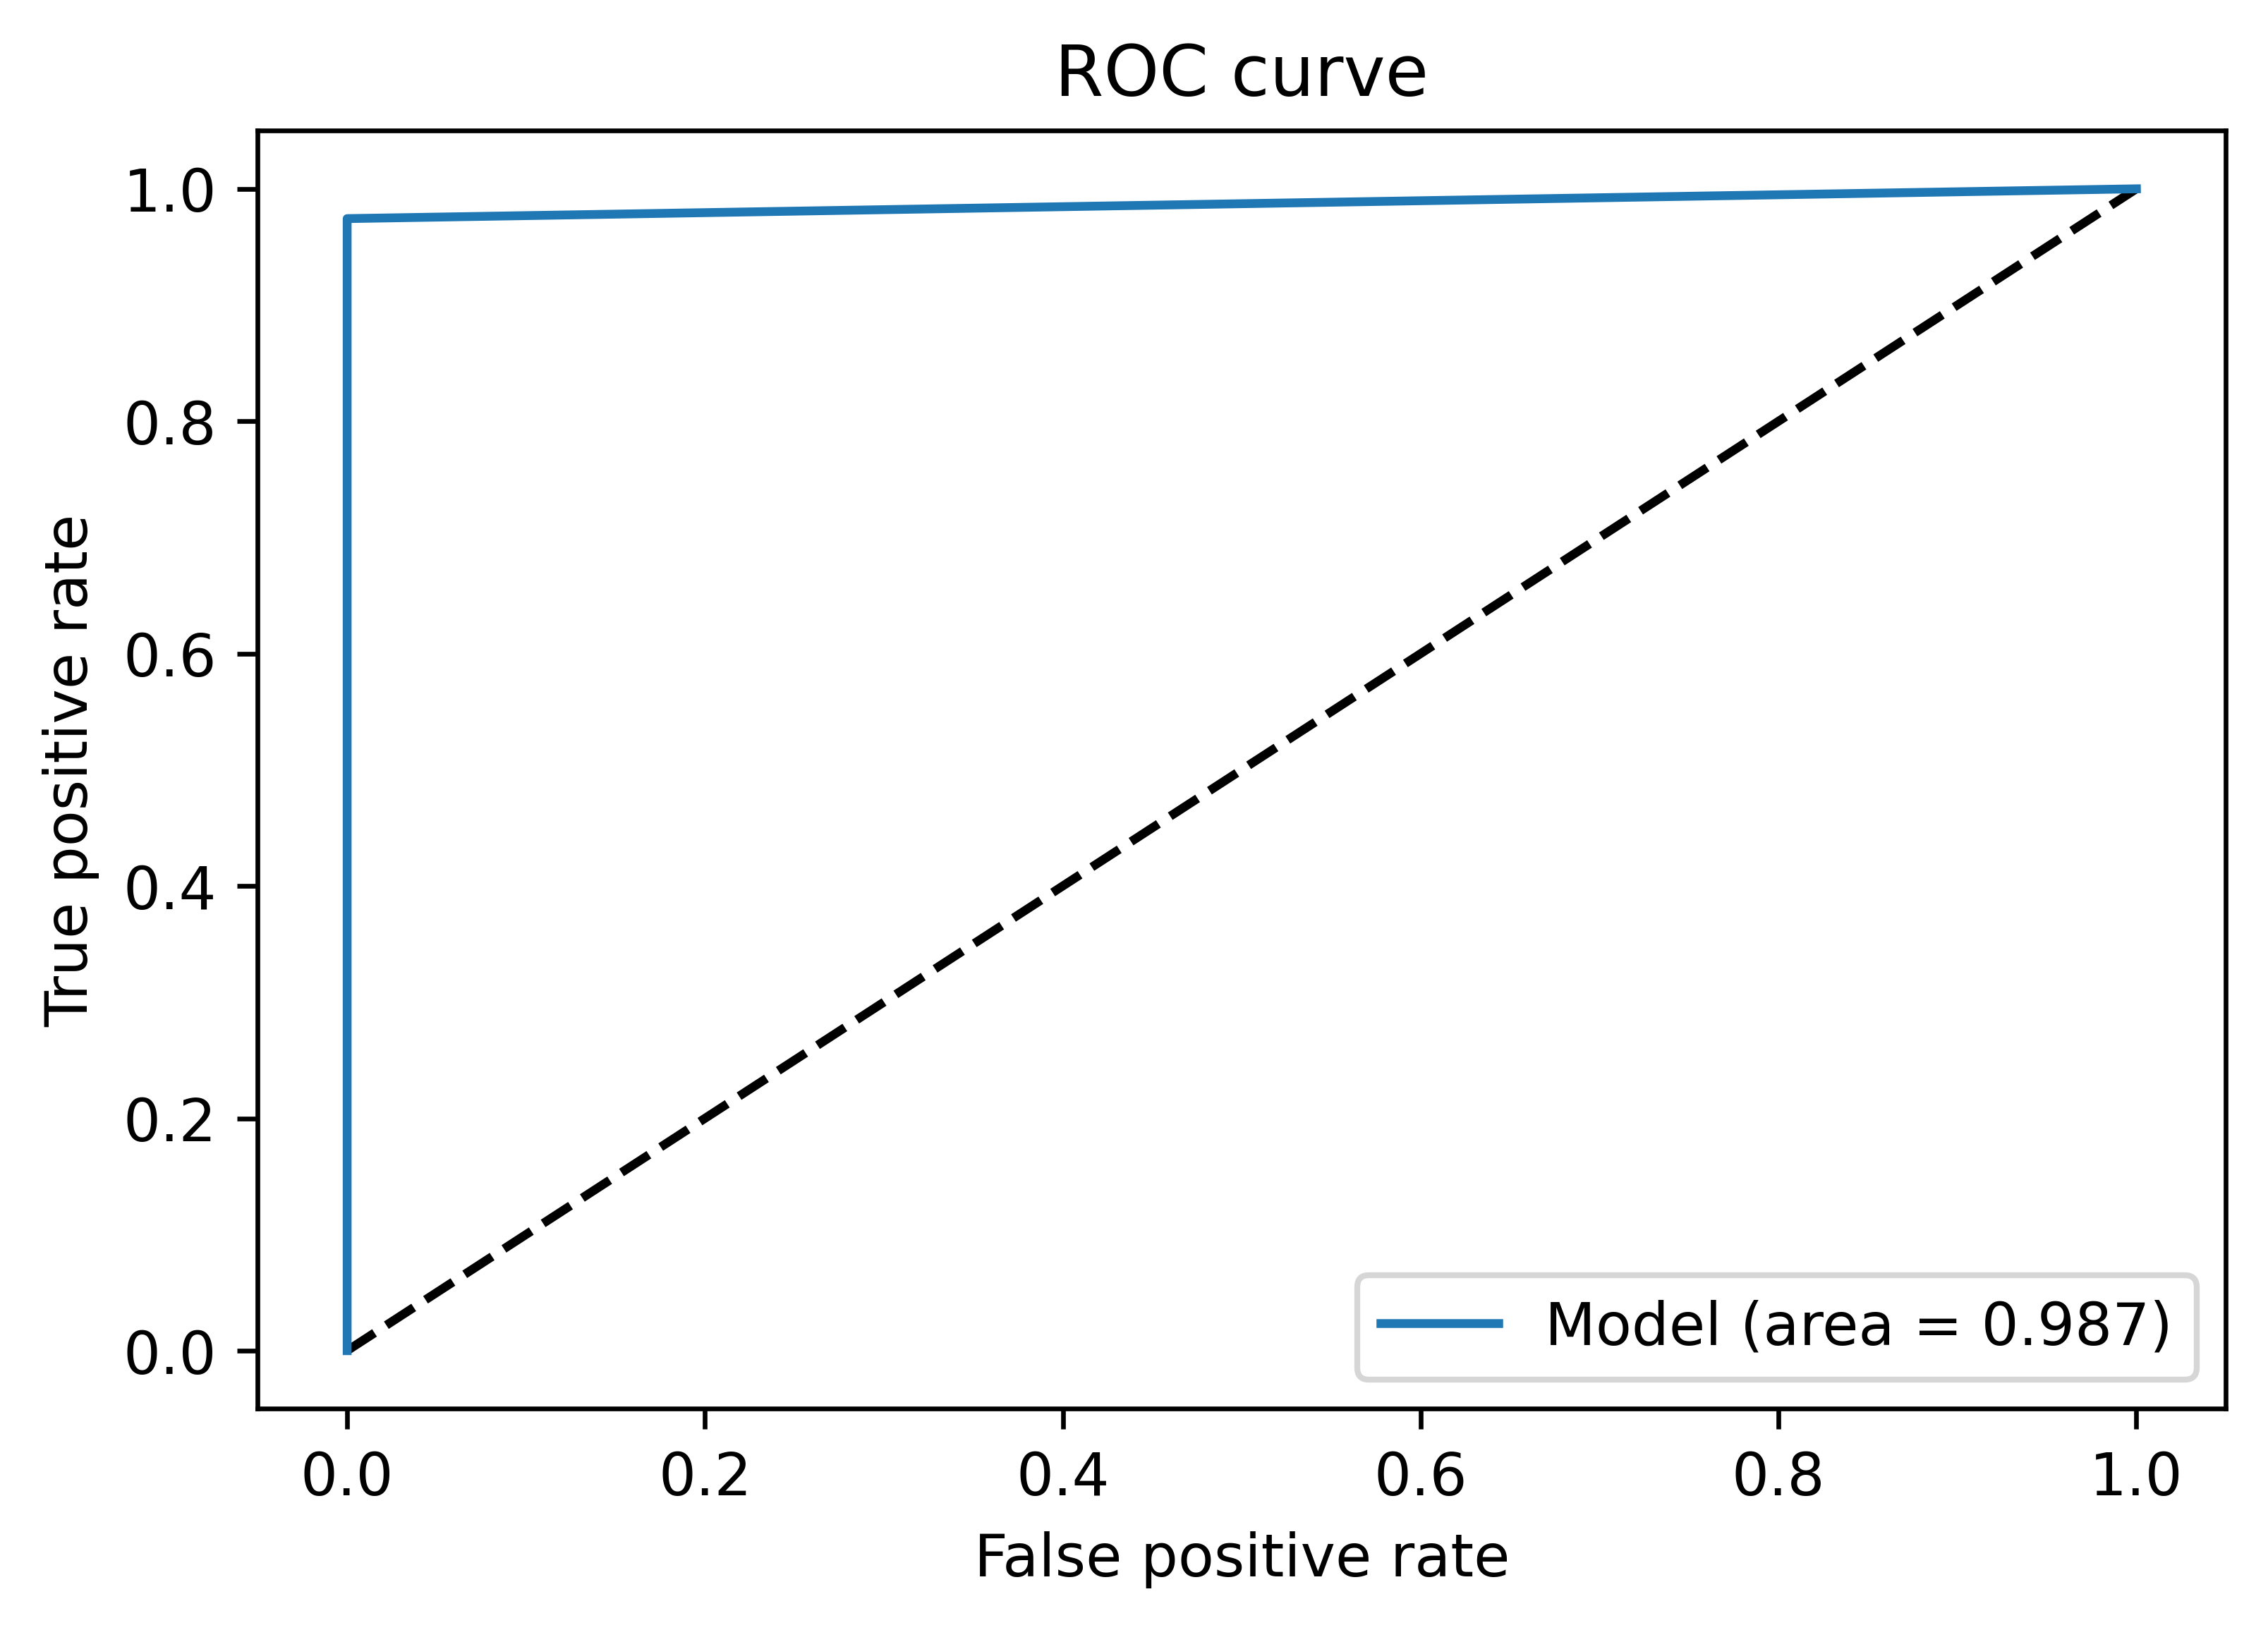

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(tfi1, tfi,pos_label=arr[0])
auc_keras = auc(fpr, tpr)
plt.figure(dpi=600)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(fi1, fi))

0.007575757575757576


In [32]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(fi1, fi, squared=False))

0.08703882797784893


In [33]:
model.save("/content/gdrive/My Drive/Covid-19/DenseNetUnsharp.h5")